In [1]:
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools
from encoder_ import *

/tmp/ipykernel_357031/2611190561.py:3: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


In [2]:
# class RLencoder(torch.nn.Module):
#     def __init__(self, time_window, fire_window_ratio):
#         super(RLencoder, self).__init__()
#         self.time_window = time_window
#         self.fire_window = int(time_window * fire_window_ratio)
#         print("time_window: ", self.time_window)
#         print("fire_window: ", self.fire_window)

#     def forward(self, x):
#         batch_size, _, height, width = x.shape
#         spikes = torch.zeros(batch_size, height, width, self.time_window).to(x.device)
#         # print("spikes.shape", spikes.shape)

#         # gray = to_grayscale(x)
#         # max_latency = 100
#         var = variance_map(x, 5)
#         latency = calculate_latency(var, self.time_window, self.fire_window, mode='log')

#         spike_prob = torch.rand(batch_size, height, width, self.time_window).to(x.device)

#         time_range = torch.arange(self.time_window).view(1, 1, 1, -1).to(x.device)
#         firing_mask = ((time_range >= latency.unsqueeze(-1)) & (time_range < (latency + self.fire_window).unsqueeze(-1))).squeeze().float()
#         # print("spikes shape", spikes.shape)
#         # print("spike_prob shape", spike_prob.shape)
#         # print("x shape", x.shape)
#         # print("firing_mask shape", firing_mask.shape)
#         x = torch.mean(x, dim=1, keepdim=True)
#         spikes = (spike_prob < x.squeeze().unsqueeze(-1)) * firing_mask
        
#         return spikes

# # def to_grayscale(image):
# #     return torch.mean(image, dim=1, keepdim=True)

# def variance_map(image, kernel_size):
#     # kernel_size : odd
    
#     pad_size = kernel_size // 2
#     padded_image = F.pad(image, pad=(pad_size, pad_size, pad_size, pad_size), mode='reflect')
    
#     local_mean = F.avg_pool2d(padded_image, kernel_size, stride=1, padding=0)
    
#     squared_image = padded_image ** 2
#     local_mean_squared = F.avg_pool2d(squared_image, kernel_size, stride=1, padding=0)
    
#     variance = local_mean_squared - local_mean ** 2
#     if variance.shape[1] != 1:
#         variance = torch.mean(variance, dim=1, keepdim=True)
    
#     return variance

# def calculate_latency(div_image, time_window, fire_window, mode='linear'):
#     min_div, max_div = div_image.min(), div_image.max()
#     normalized_div = (div_image - min_div) / (max_div - min_div)
#     if mode == "linear":
#         latency = (time_window - fire_window) * (1 - normalized_div)
#         return latency
#     elif mode == "log":
#         latency = 1/(normalized_div + 1/(time_window - fire_window))
#         return latency

In [3]:
# dataloader arguments
batch_size = 128
data_path='./data'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [ ]:
scaler = GradScaler()

In [4]:
# Define a transform
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Create DataLoaders
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [27]:
num_inputs = 32*32
num_hidden = 1000
num_outputs = 10
num_steps = 100

spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5

In [28]:
net = nn.Sequential(nn.Linear(num_inputs, num_hidden),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Linear(num_hidden, num_outputs),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [32]:
time_window = num_steps # 100
fire_window_ratio = 0.2

encoder = RLencoder(time_window, fire_window_ratio)

time_window:  100
fire_window:  20


In [37]:
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)

  spike_trains = encoder(data)
  spike_trains = spike_trains.permute(3, 0, 1, 2)

  for step in range(num_steps):
      spk_out, mem_out = net(spike_trains[step].view(batch_size, -1))
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

In [38]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec, _ = forward_pass(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [39]:
loss_fn = SF.ce_rate_loss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [40]:
num_epochs = 1
loss_hist = []
test_acc_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        # spk_rec, mem_rec = net(data.view(batch_size, -1))
        spk_rec, _ = forward_pass(net, num_steps, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        if counter % 50 == 0:
            with torch.no_grad():
                net.eval()

                # Test set forward pass
                test_acc = batch_accuracy(test_loader, net, num_steps)
                print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
                test_acc_hist.append(test_acc.item())

        counter += 1

Iteration 0, Test Acc: 9.97%

Iteration 50, Test Acc: 12.40%

Iteration 100, Test Acc: 14.16%

Iteration 150, Test Acc: 18.27%

Iteration 200, Test Acc: 19.35%

Iteration 250, Test Acc: 20.49%

Iteration 300, Test Acc: 21.13%

Iteration 350, Test Acc: 22.12%



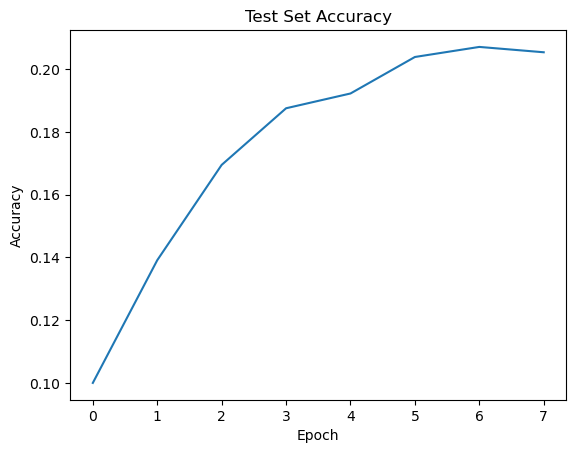

In [13]:
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [14]:
def forward_pass_test(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      spk_out, mem_out = net(data.view(data.size(0), -1))
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

In [15]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = forward_pass_test(net, num_steps, data)

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

NameError: name 'mnist_test' is not defined

In [ ]:
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9300/10000
Test Set Accuracy: 93.00%
